# 03c - BigQuery ML (BQML) - Random Forest For Classification

In this notebook, BigQuery ML (BQML) is used to create a random forest model (using XGBoost).

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
-  01 - BigQuery - Table Data Source

**Resources:**
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/03c_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/03c_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = '03c'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt

clients:

In [4]:
bq = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

---
## This Run

In [6]:
print(f'This run with create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'The Timestamp Is: {TIMESTAMP}')

This run with create BQML model: statmike-mlops-349915.fraud.03_03c_20221003125950
The Timestamp Is: 20221003125950


---
## Train Model

Use BigQuery ML to train multiclass random forest model using XGBoost:
- [Random Forest](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-random-forest) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.
    - in this example the `WHERE splits != 'TEST'` statement filters out the test data and
    - the `CASE` statement maps training data to FALSE and validation data to TRUE

In [7]:
query = f"""
CREATE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS
    (model_type = 'RANDOM_FOREST_CLASSIFIER',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        num_parallel_tree = 200,
        #early_stop = TRUE,
        #min_rel_progress = 0.01,
        tree_method = 'HIST',
        subsample = 0.85,
        colsample_bytree = 0.9
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits != 'TEST'
"""
job = bq.query(query = query)
job.result()

In [8]:
(job.ended-job.started).total_seconds()

1815.168

Add labels to the model in BigQuery:

In [9]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the iterations from training with [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [10]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.137537,0.29586,1.0,123270


### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [11]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [12]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfraud!3s03_03c_20221003125950


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [13]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TEST,0.780000,0.829787,0.999333,0.804124,0.129526,0.973328
1,TRAIN,0.794000,1.000000,0.999548,0.885173,0.129008,1.000000
2,VALIDATE,0.722222,0.812500,0.999150,0.764706,0.129857,0.991630


### Confusion Matrix

Review the confusion matrix for each split with [`ML.CONFUSION_MATRIX`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [14]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,227561,103
1,1,0,397


In [15]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28181,15
1,1,9,39


In [16]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28444,11
1,1,8,39


### ROC Curve

Retrieve the ROC Curve for each split using [`ML.ROC_CURVE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [17]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.880593,0.513854,0.000136,204,31,227633,193
1,0.146442,1.000000,0.008359,397,1903,225761,0
2,0.131668,1.000000,0.018316,397,4170,223494,0
3,0.127214,1.000000,0.028204,397,6421,221243,0
4,0.124934,1.000000,0.038416,397,8746,218918,0


In [18]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
ORDER BY false_positive_rate
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.880593,0.395833,0.000106,19,3,28193,29
1,0.148931,0.875000,0.008654,42,244,27952,6
2,0.133510,0.958333,0.018549,46,523,27673,2
3,0.128562,0.979167,0.028373,47,800,27396,1
4,0.125843,0.979167,0.038481,47,1085,27111,1


In [19]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
ORDER BY false_positive_rate
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.880593,0.468085,0.000141,22,4,28451,25
1,0.149221,0.893617,0.008505,42,242,28213,5
2,0.132674,0.893617,0.018696,42,532,27923,5
3,0.128083,0.893617,0.028571,42,813,27642,5
4,0.125751,0.914894,0.038693,43,1101,27354,4


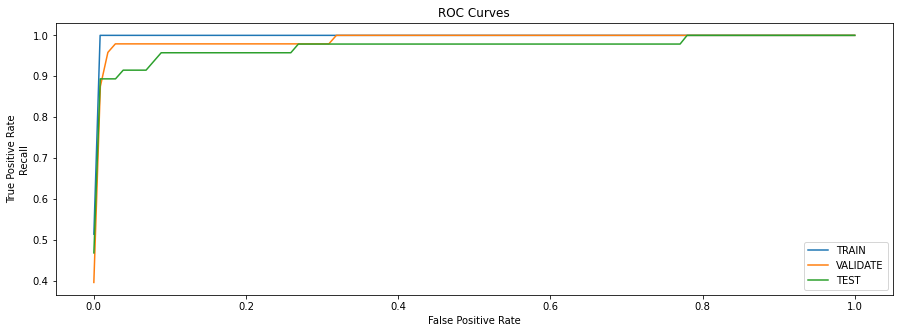

In [20]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions

Create a pandas dataframe with predictions for the test data in the table:

In [21]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [22]:
pred.columns

Index(['predicted_Class', 'predicted_Class_probs', 'Time', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id',
       'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [23]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.11956964433193207}, {'...",TEST
1,0,0,"[{'label': 1, 'prob': 0.11924473196268082}, {'...",TEST
2,0,0,"[{'label': 1, 'prob': 0.11981116235256195}, {'...",TEST
3,0,0,"[{'label': 1, 'prob': 0.12139012664556503}, {'...",TEST
4,0,0,"[{'label': 1, 'prob': 0.11925367265939713}, {'...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prop`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [24]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.8804303407669067},
  {'label': 1, 'prob': 0.11956964433193207}]]

---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [`ML.EXPLAIN_PREDICT`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [ ]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [ ]:
explain.head()

Create a plot of feature attributions for a single prediction:

In [ ]:
explanation = explain.iloc[0]['top_feature_attributions']

In [ ]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [`ML.GLOBAL_EXPLAIN`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [ ]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [ ]:
gexplain.head()

In [ ]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Feature Importance

Retrieve the [XGBoost feature importances](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.feature_importances_) for the model using [`ML.FEATURE_IMPORTANCE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance).
- importance_weight: the number of splits the feature was used in across all trees
- importance_gain: the improvement in accuracy due to splits using the feature
- importance_cover: the number of rows of data covered by splits using the feature

In [ ]:
query = f"""
SELECT *
FROM ML.FEATURE_IMPORTANCE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
feature_importance = bq.query(query = query).to_dataframe()

In [ ]:
feature_importance

---
## Serving With Vertex AI

This demonstration shows the process of exporting and registering a BQML model with Vertex AI Model Registry.  To directly integrate BQML with Vertex AI Model Registry it is now (April 1, 2022) possible at model creation time with options `vertex_ai_model_id` and `vertex_ai_model_version_alises`. See the documentation for this direct integration [here](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Export the BigQuery Model

Reference: [Export the BigQuery Model](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [ ]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = '{URI}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [ ]:
(export.ended - export.started).total_seconds()

In [ ]:
listing = !gsutil ls {URI}/models/{TIMESTAMP}/model
listing

In [ ]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{URI.split('//')[-1]}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

### Detect The Model Types Framework

In [ ]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(filetypes) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

Set the `DEPLOY_IMAGE` based on the framework:

In [ ]:
if framework == 'TensorFlow':
    DEPLOY_IMAGE = TF_DEPLOY_IMAGE
elif framework == 'XGBoost':
    DEPLOY_IMAGE = XGB_DEPLOY_IMAGE
    
DEPLOY_IMAGE

### Upload The Model To Vertex AI Model Registry
References:
- Python SDK for [`aiplatform.Model`](https://googleapis.dev/python/aiplatform/latest/aiplatform/services.html#google.cloud.aiplatform.Model)
- Python Client for [`aiplatform.Model`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [ ]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model =  modelmatch[0].resource_name
else:
    print('This is a new model, adding to model registry as version 1')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model = parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/models/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'timestamp': f'{TIMESTAMP}', 'run_name' : f'{RUN_NAME}', 'framework' : f'{framework.lower()}'}
    )  

In [ ]:
model.display_name

In [ ]:
model.resource_name

In [ ]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/model_{SERIES}_{EXPERIMENT}?project={PROJECT_ID}")

---
## Online Predictions with Vertex AI Endpoints
Check out the notebook [03Tools - Predictions](./03Tools%20-%20Predictions.ipynb) to see how to use this model with [online predictions in Vertex AI](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models).

---
## Remove Resources
see notebook "99 - Cleanup"